# Genetic Algorithm for Feature Selection

A Genetic Algorithm for feature selection is an evolutionary approach inspired by natural selection that can be very effective for selecting optimal feature subsets. It is particularly useful when the feature space is large, complex, or highly non-linear. The steps involve:

1. Initialization: Generate an initial population of random feature subsets.
2. Evaluation: Train a model using each feature subset and evaluate its performance 
3. Selection: Choose the best-performing feature subsets as parents for the next generation.
4. Crossover: Combine pairs of parent feature subsets to create offspring by mixing their features.
5. Mutation: Introduce small random changes to some offspring to maintain diversity and avoid local optima.
6. Replacement: Replace the worst-performing feature subsets in the population with the new offspring.
7. Iteration: Repeat the process until a stopping criterion is met

Genetic Algorithms can capture complex, non-linear relationships between features, can be used with any type of model, and perform a comprehensive search of the feature space. The script is adapted from the tutorial found here https://medium.com/@ela.markovic/feature-selection-using-genetic-algorithm-complete-beginner-friendly-guide-198496393728 


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import random
from tqdm import tqdm

### Hyperparameters

In [2]:
# Minimum number of features an individual (a molecule) can have
min_features = 5 
# Maximum number of features an individual (a molecule) can have
max_features = 50 

# The number of individuals in the population. This determines how many candidate solutions
# (feature subsets) are considered in each generation.
population_size = 50 

max_iterations = 20 # Maximum number of generations

# The percentage of the population that will be preserved as elite. Elite individuals
# are kept without change and passed directly to the next generation.
elite_percent = 0.4 

# The probability that a mutation will occur in an individual. Mutation introduces variability
# by flipping feature selections (0 to 1 or 1 to 0) within the individual.
mutation_probability = 0.3 # Probability of mutation


model_types = ['random_forest', 'xgboost', 'linear_regression', 'svr'] # List of model types to iterate over

## Functions to use

### Create an initial population (step 1)

In [3]:
# Function to generate random individuals (feature subsets)
def generate_random_individuals(population_size, num_features, min_features, max_features):
    """
    Generate a population of random individuals represented as binary vectors.

    Parameters:
    population_size (int): Number of individuals in the population.
    num_features (int): Total number of features available.
    min_features (int): Minimum number of features to include in an individual.
    max_features (int): Maximum number of features to include in an individual.

    Returns:
    np.ndarray: A 2D array where each row is a binary vector representing an individual.
    """
    # Initialize the matrix with zeros. if a feature (column) in a population (row) is selected, it will be changed to 1
    individuals = np.zeros((population_size, num_features)) 
    # Loop over the population (in this case, the compounds) and randomly select a set of features to keep 
    for i in range(population_size):
        # Generate a random number of ones (random number of features to keep), which is between min_features and max_features
        num_ones = np.random.randint(min_features, max_features + 1)
        # Randomly assign the ones to features describing the compounds
        ones_indices = np.random.choice(num_features, num_ones, replace=False) #indices that the ones will be assigned to
        individuals[i, ones_indices] = 1 #assign the ones at the indices
    return individuals

### Train a model on every chromosome from the population and calculate accuracy (steps 2 & 3)

This `train_model` function is designed to train a specified regression model with appropriate regularization, evaluate its performance using cross-validation, and calculate an average R² score to assess model reliability. It starts by selecting only the predictor features specified by predictor_names from the training and test datasets. Based on the model type provided (`random_forest`, `xgboost`, `linear_regression`, or `svr`), the function initializes a model with built-in regularization to prevent overfitting: it limits tree depth in `RandomForestRegressor`, applies both L1 and L2 regularization terms in `XGBRegressor`, uses Ridge (L2) regularization for linear regression, and sets a regularization parameter `C` for `SVR`.

The function then performs 5-fold cross-validation on the training data, obtaining an average R² score (`avg_cv_r2`) that provides a reliable performance estimate by reducing potential overfitting to any single subset of data. After cross-validation, the model is fit on the full training set and used to predict on the test set, yielding a test R² score (`test_r2`). Finally, an overall performance score (`final_score`) is calculated by averaging the cross-validation and test R² scores, giving a balanced measure of how well the model generalizes to new data.

In [4]:
# Function to train different regression models with regularization and get the R^2 score
def train_model(x_train, x_test, y_train, y_test, predictor_names, model_type):
    """
    Train a specified regression model with regularization, using cross-validation to control overfitting,
    and calculate the average R^2 score.

    Parameters:
    x_train (pd.DataFrame): Training feature set.
    x_test (pd.DataFrame): Test feature set.
    y_train (pd.Series): Training target values.
    y_test (pd.Series): Test target values.
    predictor_names (list): List of feature names to include in the model.
    model_type (str): The type of regression model ('random_forest', 'xgboost', 'linear_regression', 'svr').

    Returns:
    float: Average R^2 score of the model from cross-validation.
    """

    x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
        x_train.loc[:, predictor_names], y_train, test_size=0.2, random_state=1
    )

    # Initialize the model with regularization based on the specified type
    if model_type == 'random_forest':
        mdl = RandomForestRegressor(random_state=1, max_depth=10, min_samples_split=5, min_samples_leaf=2)
    elif model_type == 'xgboost':
        mdl = XGBRegressor(objective='reg:squarederror', random_state=1, alpha=0.1, reg_lambda=1.0)
    elif model_type == 'linear_regression':
        mdl = Ridge(alpha=1.0)
    elif model_type == 'svr':
        mdl = SVR(C=1.0)
    else:
        raise ValueError("Unsupported model type")

    # Fit on the training split and evaluate on the validation split
    mdl.fit(x_train_split, y_train_split)
    y_val_pred = mdl.predict(x_val_split)
    val_r2 = r2_score(y_val_split, y_val_pred)  # R^2 score on validation set

    # Evaluate on the test set for an independent assessment
    y_test_pred = mdl.predict(x_test.loc[:, predictor_names])
    test_r2 = r2_score(y_test, y_test_pred)  # R^2 score on test set

    # Calculate a blended final score
    final_score = (val_r2 + test_r2) / 2
    return final_score
    

### Select parents (step 4)

This function chooses parents for the next generation using a combination of elite selection (based on accuracy) and a roulette wheel selection strategy to ensure that well-performing individuals have a higher chance of being selected while maintaining diversity.

The first few lines inside the function calculate the number of elite individuals to keep based on `elite_percent`, sort the individuals in the population in descending order of fitness scores using `np.argsort(-accuracy)`, and select the top `elite_num` individuals as the elite population. The calculation `elite_num = int(round(((elite_percent * population.shape[0]) // 2) * 2))` ensures that `elite_num` is always even so that each elite individual has a potential partner for mating. The `elite_population` array contains these elite individuals that will be preserved for the next generation without mutation.

The rest of the parents are picked based on their accuracy scores using a roulette wheel selection strategy. The `accuracy` array holds the R^2 scores for each individual in the population. The process works as follows:
1. The accuracy scores are normalized to create a weight distribution, and cumulative weights are calculated to represent the total fitness distribution.
2. A random number between 0 and the total cumulative weight is generated to simulate the roulette wheel.
3. The function uses `np.searchsorted` to find the index where the random number fits within the cumulative weights. This index corresponds to a selected chromosome, with higher accuracy scores having greater weights and thus a higher probability of selection.

The function returns an array of chosen parents, which includes both the elite individuals and non-elite individuals selected by the roulette wheel method. This approach maintains a balance between retaining the best-performing solutions and introducing diversity for the next generation.


In [5]:
# Function to choose parents based on performance
def choose_parents(population, accuracy, elite_percent):
    """
    Select parents for the next generation based on performance.

    Parameters:
    population (np.ndarray): Current population of individuals.
    accuracy (np.ndarray): Array of R^2 scores for each individual.
    elite_percent (float): Percentage of top individuals to preserve as elite.

    Returns:
    np.ndarray: Selected parents for crossover.
    """
    # Get the number of elite numbers based on the percent of the elite, and ensure that the number is even
    elite_num = int(round(((elite_percent * population.shape[0]) // 2) * 2))
    # The accuracy scores of each individual (chromosome) in the population, to be sorted in descending order
    ind_ac = np.argsort(-accuracy)
    # Get the elite population 
    top_perc = ind_ac[:elite_num] #get the elite indices
    elite_population = population[top_perc, :] #keep the elite population

    # Normalize accuracy to obtain weights for roulette wheel selection
    weight_norm = accuracy / accuracy.sum() # calculate normalised weight from accuracy
    weight_comu = weight_norm.cumsum() # calculate cumulative weight from accuracy

    # Roulette wheel selection
    num_parents_wo_elite = population.shape[0] - elite_num # Number of non-elite parents to select
    parents_wo_elite = np.empty([num_parents_wo_elite, population.shape[1]]) # Initialize array of parents that are no elites
    for count in range(num_parents_wo_elite): # Loop over all the population that's not elite
        rand_num = np.random.uniform(0, weight_comu[-1]) # Generate a random number within the cumulative distribution
        indices = np.searchsorted(weight_comu, rand_num) # Find the index in the cumulative array that matches or exceeds rand_num
        parents_wo_elite[count, :] = population[indices, :] # Select the individual at this index

    parents = np.concatenate((elite_population, parents_wo_elite), axis=0) # Combine elite and non-elite parents into one array
    return parents

### Generate children and mutate with probability (step 5 & 6)

The function first calculates the number of elite individuals based on the `elite_percentinput`, and then selects the elite individuals to be directly passed on to the next generation. The remaining children are created using the one-point crossover method, where pairs of parents are selected and a random crossover point is chosen. The children are created by combining the first part of one parent and the second part of the other parent after the crossover point.

After the crossover operation, the function checks if each child has between the minimum number of features and maximum number of features. If the number of 1s (true values) is greater than the maximum allowed number of features, some of the true values are randomly changed to false values. Similarly, if the number of 1s is less than the minimum allowed number of features, some of the false values are randomly changed to true values.

Finally, the function performs mutation by randomly selecting some bits in the child and flipping them from 0 to 1 or from 1 to 0 based on the mutation probability and the number of features already present in the offspring.

The output of the function is a 2D numpy array representing the child population after the one-point crossover and mutation operations.



In [6]:
def one_point_crossover(parents, elite_percent, mutation_probability, min_features, max_features):
    """
    Perform one-point crossover and mutation to generate new individuals.

    Parameters:
    parents (np.ndarray): Array of selected parents.
    elite_percent (float): Percentage of parents to keep as elite.
    mutation_probability (float): Probability of mutation occurring in an individual.
    min_features (int): Minimum number of features to include in an individual.
    max_features (int): Maximum number of features to include in an individual.

    Returns:
    np.ndarray: New population generated after crossover and mutation.
    """
    # Calculate the number of elite individuals to retain (always even for pairing).
    elite_num = int(round(((elite_percent * parents.shape[0]) // 2) * 2))
    
    # Initialize the new population with zeros, having the same shape as parents.
    crossover_population = np.zeros((parents.shape[0], parents.shape[1]))
    
    # Copy elite individuals directly into the new population.
    crossover_population[0:elite_num, :] = parents[0:elite_num, :]

    # Perform one-point crossover for the remaining individuals.
    for ii in range(int((parents.shape[0] - elite_num) / 2)):
        n = 2 * ii + elite_num  # Index for selecting parent pairs for crossover.
        parents_couple = parents[n:n + 2, :]  # Select two consecutive parents.
        rand_n = np.random.randint(1, parents.shape[1] - 1)  # Random crossover point (not at the boundaries).
        
        # Create two new offspring by splitting and combining the parent chromosomes at rand_n.
        crossover_population[n, :] = np.concatenate([parents_couple[0, :rand_n], parents_couple[1, rand_n:]])
        crossover_population[n + 1, :] = np.concatenate([parents_couple[1, :rand_n], parents_couple[0, rand_n:]])

    # Ensure that each individual's feature count stays within min and max limits.
    for kk in range(crossover_population.shape[0]):
        Sum = np.sum(crossover_population[kk, :])  # Total number of selected features in an individual.
        if Sum > max_features:  # If it exceeds the max limit:
            excess = int(Sum - max_features)  # Number of features to remove.
            indices = np.where(crossover_population[kk, :] == 1)[0]  # Indices of selected features.
            position1 = np.random.choice(indices, size=excess, replace=False)  # Randomly choose features to turn off.
            crossover_population[kk, position1] = 0  # Set them to 0.
        elif Sum < min_features:  # If it falls below the min limit:
            missing = int(min_features - Sum)  # Number of features to add.
            indices = np.where(crossover_population[kk, :] == 0)[0]  # Indices of unselected features.
            position2 = np.random.choice(indices, size=missing, replace=False)  # Randomly choose features to turn on.
            crossover_population[kk, position2] = 1  # Set them to 1.

    # Introduce mutations randomly based on the mutation probability.
    num_mutations = round(crossover_population.size * mutation_probability)  # Total number of mutations.
    for _ in range(num_mutations):
        ind_row = np.random.randint(0, crossover_population.shape[0])  # Random individual in the population.
        ind_col = np.random.randint(0, crossover_population.shape[1])  # Random feature position in the individual.
        
        # Mutate the feature (toggle between 0 and 1) while adhering to feature count constraints.
        if (crossover_population[ind_row, ind_col] == 0 and np.sum(crossover_population[ind_row, :]) < max_features):
            crossover_population[ind_row, ind_col] = 1  # Turn on a feature if within max limit.
        elif (crossover_population[ind_row, ind_col] == 1 and np.sum(crossover_population[ind_row, :]) >= min_features + 1):
            crossover_population[ind_row, ind_col] = 0  # Turn off a feature if above min limit.

    # Return the new population after crossover and mutation.
    return crossover_population

## Read inputs and run 

In [7]:
# Read inputs. Note: performing feature selection is done on the training set
dataset = pd.read_csv('../3_train_test_split/train_set.csv')

X = dataset.drop(columns=['-logIC50'])
y = dataset['-logIC50']
num_features = X.shape[1]

Running genetic algorithm for model: random_forest


Progress for random_forest:   0%|                                                                                            | 0/19 [00:00<?, ?gen/s]

Begin iteration num 2/20


Progress for random_forest:   5%|████▍                                                                               | 1/19 [00:42<12:36, 42.01s/gen]

Begin iteration num 3/20


Progress for random_forest:  11%|████████▊                                                                           | 2/19 [01:21<11:27, 40.44s/gen]

Begin iteration num 4/20


Progress for random_forest:  16%|█████████████▎                                                                      | 3/19 [02:01<10:46, 40.41s/gen]

Begin iteration num 5/20


Progress for random_forest:  21%|█████████████████▋                                                                  | 4/19 [02:42<10:09, 40.66s/gen]

Begin iteration num 6/20


Progress for random_forest:  26%|██████████████████████                                                              | 5/19 [03:24<09:35, 41.13s/gen]

Begin iteration num 7/20


Progress for random_forest:  32%|██████████████████████████▌                                                         | 6/19 [04:03<08:46, 40.48s/gen]

Begin iteration num 8/20


Progress for random_forest:  37%|██████████████████████████████▉                                                     | 7/19 [04:41<07:52, 39.41s/gen]

Begin iteration num 9/20


Progress for random_forest:  42%|███████████████████████████████████▎                                                | 8/19 [05:18<07:07, 38.83s/gen]

Begin iteration num 10/20


Progress for random_forest:  47%|███████████████████████████████████████▊                                            | 9/19 [05:58<06:29, 39.00s/gen]

Begin iteration num 11/20


Progress for random_forest:  53%|███████████████████████████████████████████▋                                       | 10/19 [06:38<05:55, 39.49s/gen]

Begin iteration num 12/20


Progress for random_forest:  58%|████████████████████████████████████████████████                                   | 11/19 [07:18<05:16, 39.54s/gen]

Begin iteration num 13/20


Progress for random_forest:  63%|████████████████████████████████████████████████████▍                              | 12/19 [07:56<04:33, 39.13s/gen]

Begin iteration num 14/20


Progress for random_forest:  68%|████████████████████████████████████████████████████████▊                          | 13/19 [08:35<03:54, 39.00s/gen]

Begin iteration num 15/20


Progress for random_forest:  74%|█████████████████████████████████████████████████████████████▏                     | 14/19 [09:13<03:13, 38.77s/gen]

Begin iteration num 16/20


Progress for random_forest:  79%|█████████████████████████████████████████████████████████████████▌                 | 15/19 [09:51<02:33, 38.40s/gen]

Begin iteration num 17/20


Progress for random_forest:  84%|█████████████████████████████████████████████████████████████████████▉             | 16/19 [10:28<01:54, 38.01s/gen]

Begin iteration num 18/20


Progress for random_forest:  89%|██████████████████████████████████████████████████████████████████████████▎        | 17/19 [11:05<01:15, 37.90s/gen]

Begin iteration num 19/20


Progress for random_forest:  95%|██████████████████████████████████████████████████████████████████████████████▋    | 18/19 [11:42<00:37, 37.47s/gen]

Begin iteration num 20/20


Progress for random_forest: 100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [12:19<00:00, 38.89s/gen]


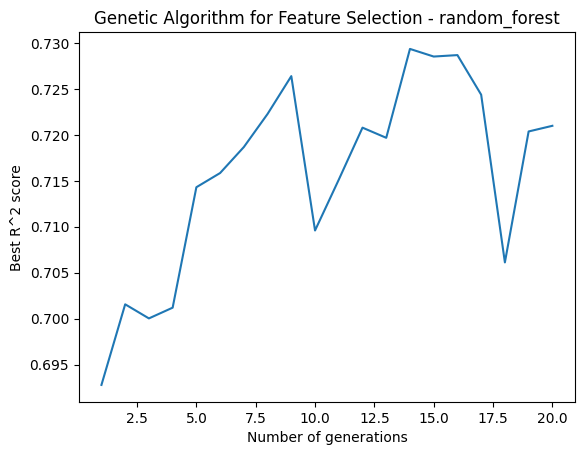

Best features selected for random_forest: Index(['PBF', 'GETAWAY_7', 'GETAWAY_19', 'GETAWAY_21', 'GETAWAY_46',
       'GETAWAY_73', 'GETAWAY_78', 'GETAWAY_146', 'GETAWAY_152', 'GETAWAY_173',
       'GETAWAY_224', 'GETAWAY_238', 'GETAWAY_239', 'GETAWAY_271', 'WHIM_7',
       'WHIM_18', 'WHIM_35', 'WHIM_63', 'WHIM_85', 'WHIM_106', 'MORSE_24',
       'MORSE_46', 'MORSE_59', 'MORSE_90', 'MORSE_99', 'MORSE_119',
       'MORSE_124', 'MORSE_133', 'MORSE_186', 'MORSE_196', 'RDF_9', 'RDF_30',
       'RDF_118', 'RDF_154', 'RDF_164', 'RDF_171', 'RDF_181', 'AUTOCORR3D_0',
       'AUTOCORR3D_7', 'AUTOCORR3D_15', 'AUTOCORR3D_23', 'AUTOCORR3D_51',
       'AUTOCORR3D_54', 'AUTOCORR3D_77', 'LUMO', 'PEOE_VSA2', 'GGI10', 'JGI6',
       'JGT', 'ringCount'],
      dtype='object')
Running genetic algorithm for model: xgboost


Progress for xgboost:   0%|                                                                                                  | 0/19 [00:00<?, ?gen/s]

Begin iteration num 2/20


Progress for xgboost:   5%|████▋                                                                                     | 1/19 [00:10<03:13, 10.76s/gen]

Begin iteration num 3/20


Progress for xgboost:  11%|█████████▍                                                                                | 2/19 [00:22<03:10, 11.20s/gen]

Begin iteration num 4/20


Progress for xgboost:  16%|██████████████▏                                                                           | 3/19 [00:34<03:10, 11.89s/gen]

Begin iteration num 5/20


Progress for xgboost:  21%|██████████████████▉                                                                       | 4/19 [00:47<03:00, 12.02s/gen]

Begin iteration num 6/20


Progress for xgboost:  26%|███████████████████████▋                                                                  | 5/19 [01:00<02:52, 12.32s/gen]

Begin iteration num 7/20


Progress for xgboost:  32%|████████████████████████████▍                                                             | 6/19 [01:13<02:46, 12.84s/gen]

Begin iteration num 8/20


Progress for xgboost:  37%|█████████████████████████████████▏                                                        | 7/19 [01:37<03:15, 16.29s/gen]

Begin iteration num 9/20


Progress for xgboost:  42%|█████████████████████████████████████▉                                                    | 8/19 [02:01<03:27, 18.87s/gen]

Begin iteration num 10/20


Progress for xgboost:  47%|██████████████████████████████████████████▋                                               | 9/19 [02:20<03:07, 18.79s/gen]

Begin iteration num 11/20


Progress for xgboost:  53%|██████████████████████████████████████████████▊                                          | 10/19 [02:36<02:40, 17.84s/gen]

Begin iteration num 12/20


Progress for xgboost:  58%|███████████████████████████████████████████████████▌                                     | 11/19 [02:51<02:16, 17.03s/gen]

Begin iteration num 13/20


Progress for xgboost:  63%|████████████████████████████████████████████████████████▏                                | 12/19 [03:06<01:55, 16.52s/gen]

Begin iteration num 14/20


Progress for xgboost:  68%|████████████████████████████████████████████████████████████▉                            | 13/19 [03:21<01:36, 16.10s/gen]

Begin iteration num 15/20


Progress for xgboost:  74%|█████████████████████████████████████████████████████████████████▌                       | 14/19 [03:37<01:20, 16.05s/gen]

Begin iteration num 16/20


Progress for xgboost:  79%|██████████████████████████████████████████████████████████████████████▎                  | 15/19 [03:53<01:03, 16.00s/gen]

Begin iteration num 17/20


Progress for xgboost:  84%|██████████████████████████████████████████████████████████████████████████▉              | 16/19 [04:09<00:48, 16.07s/gen]

Begin iteration num 18/20


Progress for xgboost:  89%|███████████████████████████████████████████████████████████████████████████████▋         | 17/19 [04:25<00:31, 15.99s/gen]

Begin iteration num 19/20


Progress for xgboost:  95%|████████████████████████████████████████████████████████████████████████████████████▎    | 18/19 [04:41<00:16, 16.01s/gen]

Begin iteration num 20/20


Progress for xgboost: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 19/19 [04:58<00:00, 15.70s/gen]


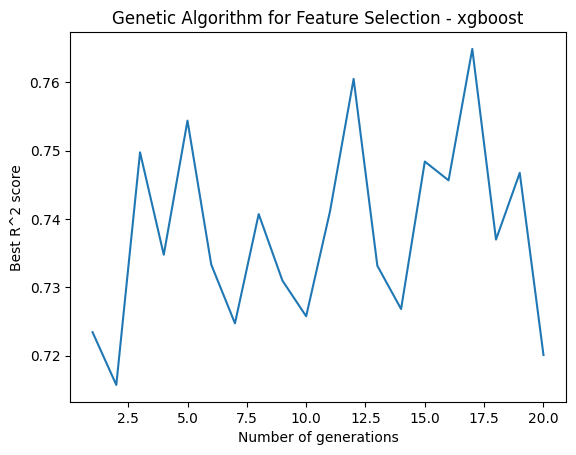

Best features selected for xgboost: Index(['GETAWAY_3', 'GETAWAY_10', 'GETAWAY_58', 'GETAWAY_81', 'GETAWAY_88',
       'GETAWAY_89', 'GETAWAY_94', 'GETAWAY_105', 'GETAWAY_108', 'GETAWAY_136',
       'GETAWAY_145', 'GETAWAY_146', 'GETAWAY_174', 'GETAWAY_196',
       'GETAWAY_206', 'GETAWAY_228', 'GETAWAY_257', 'GETAWAY_259',
       'GETAWAY_261', 'WHIM_28', 'WHIM_50', 'WHIM_54', 'WHIM_85', 'MORSE_39',
       'MORSE_110', 'MORSE_115', 'MORSE_196', 'RDF_46', 'RDF_48', 'RDF_57',
       'RDF_86', 'RDF_120', 'RDF_121', 'RDF_122', 'RDF_154', 'RDF_156',
       'RDF_158', 'RDF_179', 'RDF_190', 'AUTOCORR3D_2', 'AUTOCORR3D_17',
       'AUTOCORR3D_44', 'AUTOCORR3D_49', 'AUTOCORR3D_61', 'AUTOCORR3D_66',
       'HOMO', 'TPSA', 'Kappa2', 'PEOE_VSA6', 'rotatableBonds'],
      dtype='object')
Running genetic algorithm for model: linear_regression


Progress for linear_regression:   0%|                                                                                        | 0/19 [00:00<?, ?gen/s]

Begin iteration num 2/20


Progress for linear_regression:   5%|████▏                                                                           | 1/19 [00:00<00:14,  1.24gen/s]

Begin iteration num 3/20


Progress for linear_regression:  11%|████████▍                                                                       | 2/19 [00:01<00:13,  1.23gen/s]

Begin iteration num 4/20


Progress for linear_regression:  16%|████████████▋                                                                   | 3/19 [00:02<00:12,  1.24gen/s]

Begin iteration num 5/20


Progress for linear_regression:  21%|████████████████▊                                                               | 4/19 [00:03<00:11,  1.25gen/s]

Begin iteration num 6/20


Progress for linear_regression:  26%|█████████████████████                                                           | 5/19 [00:04<00:11,  1.23gen/s]

Begin iteration num 7/20


Progress for linear_regression:  32%|█████████████████████████▎                                                      | 6/19 [00:04<00:10,  1.23gen/s]

Begin iteration num 8/20


Progress for linear_regression:  37%|█████████████████████████████▍                                                  | 7/19 [00:05<00:09,  1.24gen/s]

Begin iteration num 9/20


Progress for linear_regression:  42%|█████████████████████████████████▋                                              | 8/19 [00:06<00:08,  1.24gen/s]

Begin iteration num 10/20


Progress for linear_regression:  47%|█████████████████████████████████████▉                                          | 9/19 [00:07<00:08,  1.24gen/s]

Begin iteration num 11/20


Progress for linear_regression:  53%|█████████████████████████████████████████▌                                     | 10/19 [00:08<00:07,  1.24gen/s]

Begin iteration num 12/20


Progress for linear_regression:  58%|█████████████████████████████████████████████▋                                 | 11/19 [00:08<00:06,  1.25gen/s]

Begin iteration num 13/20


Progress for linear_regression:  63%|█████████████████████████████████████████████████▉                             | 12/19 [00:09<00:05,  1.26gen/s]

Begin iteration num 14/20


Progress for linear_regression:  68%|██████████████████████████████████████████████████████                         | 13/19 [00:10<00:04,  1.27gen/s]

Begin iteration num 15/20


Progress for linear_regression:  74%|██████████████████████████████████████████████████████████▏                    | 14/19 [00:11<00:03,  1.28gen/s]

Begin iteration num 16/20


Progress for linear_regression:  79%|██████████████████████████████████████████████████████████████▎                | 15/19 [00:11<00:03,  1.27gen/s]

Begin iteration num 17/20


Progress for linear_regression:  84%|██████████████████████████████████████████████████████████████████▌            | 16/19 [00:12<00:02,  1.30gen/s]

Begin iteration num 18/20


Progress for linear_regression:  89%|██████████████████████████████████████████████████████████████████████▋        | 17/19 [00:13<00:01,  1.31gen/s]

Begin iteration num 19/20


Progress for linear_regression:  95%|██████████████████████████████████████████████████████████████████████████▊    | 18/19 [00:14<00:00,  1.32gen/s]

Begin iteration num 20/20


Progress for linear_regression: 100%|███████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.27gen/s]


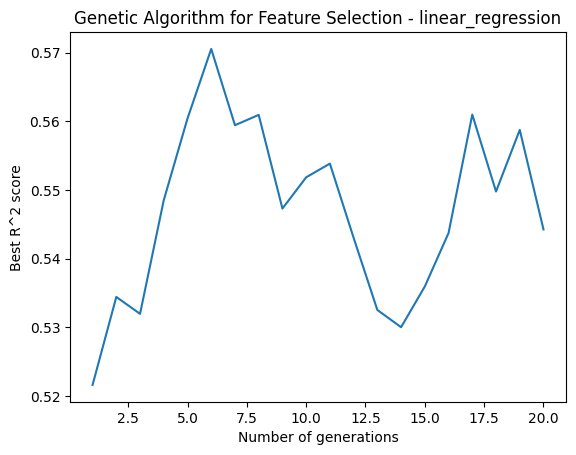

Best features selected for linear_regression: Index(['GETAWAY_39', 'GETAWAY_52', 'GETAWAY_65', 'GETAWAY_76', 'GETAWAY_86',
       'GETAWAY_111', 'GETAWAY_113', 'GETAWAY_116', 'GETAWAY_137',
       'GETAWAY_141', 'GETAWAY_173', 'GETAWAY_186', 'GETAWAY_194',
       'GETAWAY_210', 'GETAWAY_238', 'GETAWAY_267', 'WHIM_16', 'WHIM_98',
       'MORSE_24', 'MORSE_47', 'MORSE_61', 'MORSE_68', 'MORSE_70', 'MORSE_74',
       'MORSE_78', 'MORSE_103', 'MORSE_127', 'MORSE_142', 'MORSE_189',
       'MORSE_208', 'MORSE_222', 'RDF_10', 'RDF_19', 'RDF_40', 'RDF_87',
       'RDF_149', 'RDF_166', 'RDF_174', 'RDF_188', 'RDF_207', 'AUTOCORR3D_20',
       'AUTOCORR3D_60', 'TPSA', 'Chi3v', 'PEOE_VSA6', 'JGT', 'min_abs_charge',
       'heteroatoms', 'molLogP', 'molMR'],
      dtype='object')
Running genetic algorithm for model: svr


Progress for svr:   0%|                                                                                                      | 0/19 [00:00<?, ?gen/s]

Begin iteration num 2/20


Progress for svr:   5%|████▉                                                                                         | 1/19 [00:03<01:05,  3.64s/gen]

Begin iteration num 3/20


Progress for svr:  11%|█████████▉                                                                                    | 2/19 [00:07<01:01,  3.63s/gen]

Begin iteration num 4/20


Progress for svr:  16%|██████████████▊                                                                               | 3/19 [00:10<00:58,  3.63s/gen]

Begin iteration num 5/20


Progress for svr:  21%|███████████████████▊                                                                          | 4/19 [00:14<00:55,  3.71s/gen]

Begin iteration num 6/20


Progress for svr:  26%|████████████████████████▋                                                                     | 5/19 [00:18<00:51,  3.68s/gen]

Begin iteration num 7/20


Progress for svr:  32%|█████████████████████████████▋                                                                | 6/19 [00:21<00:45,  3.50s/gen]

Begin iteration num 8/20


Progress for svr:  37%|██████████████████████████████████▋                                                           | 7/19 [00:24<00:40,  3.38s/gen]

Begin iteration num 9/20


Progress for svr:  42%|███████████████████████████████████████▌                                                      | 8/19 [00:27<00:36,  3.35s/gen]

Begin iteration num 10/20


Progress for svr:  47%|████████████████████████████████████████████▌                                                 | 9/19 [00:30<00:32,  3.22s/gen]

Begin iteration num 11/20


Progress for svr:  53%|████████████████████████████████████████████████▉                                            | 10/19 [00:33<00:28,  3.13s/gen]

Begin iteration num 12/20


Progress for svr:  58%|█████████████████████████████████████████████████████▊                                       | 11/19 [00:37<00:25,  3.16s/gen]

Begin iteration num 13/20


Progress for svr:  63%|██████████████████████████████████████████████████████████▋                                  | 12/19 [00:39<00:21,  3.08s/gen]

Begin iteration num 14/20


Progress for svr:  68%|███████████████████████████████████████████████████████████████▋                             | 13/19 [00:42<00:18,  3.04s/gen]

Begin iteration num 15/20


Progress for svr:  74%|████████████████████████████████████████████████████████████████████▌                        | 14/19 [00:45<00:15,  3.07s/gen]

Begin iteration num 16/20


Progress for svr:  79%|█████████████████████████████████████████████████████████████████████████▍                   | 15/19 [00:48<00:12,  3.01s/gen]

Begin iteration num 17/20


Progress for svr:  84%|██████████████████████████████████████████████████████████████████████████████▎              | 16/19 [00:51<00:08,  2.93s/gen]

Begin iteration num 18/20


Progress for svr:  89%|███████████████████████████████████████████████████████████████████████████████████▏         | 17/19 [00:54<00:05,  2.96s/gen]

Begin iteration num 19/20


Progress for svr:  95%|████████████████████████████████████████████████████████████████████████████████████████     | 18/19 [00:57<00:03,  3.01s/gen]

Begin iteration num 20/20


Progress for svr: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [01:00<00:00,  3.19s/gen]


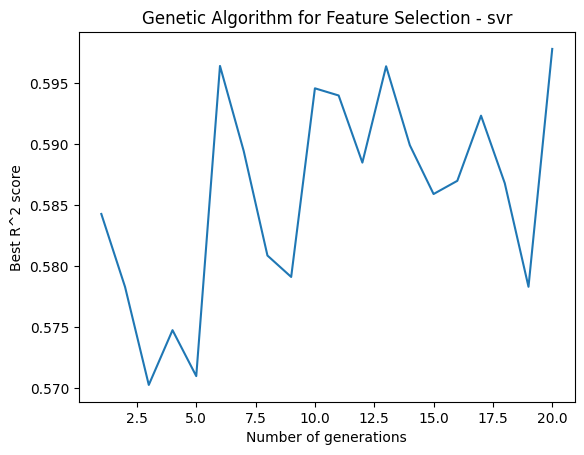

Best features selected for svr: Index(['GETAWAY_26', 'GETAWAY_28', 'GETAWAY_47', 'GETAWAY_57', 'GETAWAY_59',
       'GETAWAY_84', 'GETAWAY_94', 'GETAWAY_117', 'GETAWAY_152', 'GETAWAY_198',
       'GETAWAY_201', 'GETAWAY_211', 'GETAWAY_212', 'GETAWAY_224',
       'GETAWAY_236', 'GETAWAY_261', 'GETAWAY_263', 'WHIM_57', 'WHIM_60',
       'MORSE_16', 'MORSE_17', 'MORSE_27', 'MORSE_84', 'MORSE_122',
       'MORSE_176', 'MORSE_198', 'MORSE_217', 'RDF_48', 'RDF_60', 'RDF_61',
       'RDF_126', 'RDF_155', 'RDF_160', 'RDF_184', 'RDF_195', 'AUTOCORR3D_3',
       'AUTOCORR3D_22', 'AUTOCORR3D_27', 'AUTOCORR3D_29', 'AUTOCORR3D_34',
       'AUTOCORR3D_37', 'AUTOCORR3D_48', 'AUTOCORR3D_49', 'AUTOCORR3D_62',
       'AUTOCORR3D_67', 'Chi4v', 'GGI3', 'GGI5', 'HDonors', 'rotatableBonds'],
      dtype='object')


In [8]:
# Loop over each model type
for model_type in model_types:
    print(f'Running genetic algorithm for model: {model_type}')
    gen = 0
    population = generate_random_individuals(population_size, num_features, min_features, max_features)
    accuracy = np.zeros(population_size)
    predictor_names = X.columns

    # Initial generation evaluation
    for i in range(population_size):
        predictor_names_i = predictor_names[population[i, :] == 1]
        accuracy[i] = train_model(X, X, y, y, predictor_names_i, model_type=model_type)
        
    best_acc_i = np.zeros(max_iterations)
    best_acc_i[gen] = max(accuracy)

    # Genetic algorithm main loop with a progress bar
    with tqdm(total=max_iterations - 1, desc=f'Progress for {model_type}', unit='gen') as pbar:
        while gen < max_iterations - 1:
            print(f'Begin iteration num {gen + 2}/{max_iterations}')
            gen += 1
            parents = choose_parents(population, accuracy, elite_percent)
            children = one_point_crossover(parents, elite_percent, mutation_probability, min_features, max_features)
            population = children
            
            # Evaluate new population
            for ind in range(population_size):
                predictor_names_ind = predictor_names[population[ind, :] == 1]
                accuracy[ind] = train_model(X, X, y, y, predictor_names_ind, model_type=model_type)
            
            best_acc_i[gen] = max(accuracy)
            pbar.update(1)  # Update progress bar for each generation

    # Find the best feature subset from the final generation
    ind_max_acc = np.argmax(accuracy)
    best_features = population[ind_max_acc, :]
    best_features_names = predictor_names[best_features == 1]

    # Save the best features to CSV
    best_features_df = pd.DataFrame(best_features_names, columns=['Selected Features'])
    csv_filename = f'genetic_search_selected_features_{model_type}.csv'
    best_features_df.to_csv(csv_filename, index=False)

    mpl.rcParams["axes.formatter.limits"] = (-99, 99)
    # Plot the best accuracy over generations
    plt.plot(range(1, max_iterations + 1), best_acc_i)
    plt.xlabel('Number of generations')
    plt.ylabel('Best R^2 score')
    plt.title(f'Genetic Algorithm for Feature Selection - {model_type}')
    plt.savefig(f'genetic_algorithm_plot_{model_type}.png', dpi=150)
    plt.show()

    print(f"Best features selected for {model_type}: {best_features_names}")
    